In [13]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

from pathlib import Path
from typing import Any, Literal

import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urlparse

import numpy as np
import pandas as pd
import torch
from PIL import Image
from numpy.typing import NDArray
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from transformers import AutoFeatureExtractor, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import json
import os
import plotly.express as px


from tabulate import tabulate

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

porter = PorterStemmer()
lancaster = LancasterStemmer()
wordnet = WordNetLemmatizer()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Main processing

## Crawling and scraping

run the spider:

scrapy runspider my_spider.py
additional parameters:
* -a max_links # maximum number of links to collect
* -a start_url # starting URL
* -a min_word_count # minimum word count in text to be saved
* -a allow_random # whether to fetch random articles when stuck
* -a source_type # 'wiki' or 'fandom' to restrict to one source when fetching random articles

we already cutted out most of the characters.
* we filtered wikipedia articles so there are only correct ones
* we left only letters and numbers

## Stemming and lemmatization

In [14]:
def preprocess_text(text):

    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

def stem_lemmatize(text, technique: str):
    words = word_tokenize(text.lower())
    if technique == 'PorterStemmer':
        processed = [porter.stem(w) for w in words]
    elif technique == 'LancasterStemmer':
        processed = [lancaster.stem(w) for w in words]
    elif technique == 'WordNetLemmatizer':
        processed = [wordnet.lemmatize(w) for w in words]
    else:
        raise ValueError(f"Invalid technique: {technique}. Choose 'PorterStemmer', 'LancasterStemmer', or 'WordNetLemmatizer'.")
    return ' '.join(processed)

def process_all_articles():
    df_fandom = pd.read_csv('data/fandom.csv', encoding='utf-8')
    df_wiki = pd.read_csv('data/wiki.csv', encoding='utf-8')
    df_combined = pd.concat([df_wiki, df_fandom], ignore_index=True)
    df = df_combined.drop_duplicates().reset_index(drop = True)
    print('Data read from CSV files')

    print('Running data preprocessing, stemminization and lemmatization')
    # tokenization, lowercasing, stopword removal
    df['text_processed'] = df['text'].apply(preprocess_text)

    # stemming and lemmatization
    df['wordnet_lemmatized'] = df['text_processed'].apply(lambda x: stem_lemmatize(x, technique='WordNetLemmatizer'))

    df.to_csv('data/processed_data.csv', index=False, encoding='utf-8')
    return df

## Simple Spider

In [15]:
def is_article(url):
    parsed = urlparse(url)
    if parsed.scheme not in ('http', 'https'):
        return False

    invalid_prefixes = (
        '/wiki/wikipedia:',
        '/wiki/help:',
        '/wiki/talk:',
        '/wiki/file:',
        '/wiki/category:',
        '/wiki/template:',
        '/wiki/portal:',
        '/wiki/special:',
        '/wiki/draft:',
        '/wiki/module:',
        '/wiki/user:',
        '/wiki/forum:',
        '/wiki/message_wall:'
    )

    path = parsed.path.lower()
    return not path.startswith(invalid_prefixes)

def fetch_article(url, min_word_count=10):
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(r.text, 'html.parser')
    text = ' '.join([p.get_text() for p in soup.find_all('p')])
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if len(text.split()) < min_word_count:
        return None
    return {'url': url, 'text': text}

def run_scraper_simple(user_urls, min_word_count=10):
    for url in user_urls:
        if not is_article(url):
            print(f"Skipping non-article URL: {url}")

    data = [fetch_article(url) for url in user_urls]
    data = [d for d in data if d is not None]
    df = pd.DataFrame(data)

    df.to_csv('data/user_articles.csv', index=False, encoding='utf8')
    print("Scraping completed. Data saved to 'data/user_articles.csv'")

## Processing user input

In [16]:
# --- find top_n most diverse articles from user input ---
def most_diverse_articles(embeddings, top_n=10):
    # 1. Cluster into top_n groups
    kmeans = KMeans(n_clusters=top_n, random_state=42)
    kmeans.fit(embeddings)

    # 2. Get the index of the article closest to each cluster center
    diverse_indices = []
    for i in range(top_n):
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        centroid = kmeans.cluster_centers_[i]
        cluster_embeds = embeddings[cluster_indices]
        distances = np.linalg.norm(cluster_embeds - centroid, axis=1)
        closest_idx = cluster_indices[np.argmin(distances)]
        diverse_indices.append(closest_idx)
    return list(diverse_indices)

def process_user_articles(user_urls,
                          max_user_articles: int = 100,
                          min_word_count: int = 10):
    run_scraper_simple(user_urls)
    user_data = pd.read_csv('data/user_articles.csv', encoding='utf-8')

    if len(user_data) == 0:
        print("No valid articles were scraped from the provided URLs.")
        return None

    if len(user_data) > max_user_articles:
        user_embeddings = SentenceTransformer('all-MiniLM-L6-v2').encode(user_data['text'])
        diverse_indices = most_diverse_articles(user_embeddings, top_n=max_user_articles)
        user_data = user_data.iloc[diverse_indices].reset_index(drop=True)
        print(f"User articles reduced to {max_user_articles} most diverse articles.")

    user_data['text_processed'] = user_data['text'].apply(preprocess_text)
    user_data['wordnet_lemmatized'] = user_data['text_processed'].apply(lambda x: stem_lemmatize(x, technique='WordNetLemmatizer'))

    return user_data

## Similarity

In [37]:
def filter_recommended_articles(recommended_df, user_urls):
    if 'url' not in recommended_df.columns:
        raise ValueError("recommended_df must contain a 'url' column to filter by user URLs.")
    if not user_urls:
        return recommended_df
    filtered = recommended_df[~recommended_df['url'].isin(user_urls)].reset_index(drop=True)
    return filtered

# --- TF-IDF similarity ---
def compute_tfidf_similarity(user_text: str, articles_texts: list, max_features: int = 10000):
    # Computes cosine similarity between user text and article texts using TF-IDF.
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(articles_texts.tolist() + [user_text])
    article_tfidf = tfidf_matrix[:-1]
    user_tfidf = tfidf_matrix[-1]
    # print(f'user_text: {len(user_text)}; articles_texts: {articles_texts.shape}; tfidf: {tfidf_matrix.shape}, article_tfidf: {article_tfidf}')
    similarity = cosine_similarity(article_tfidf, user_tfidf).flatten()
    # print('tfidf:', similarity.shape)
    return similarity

# --- Embedding similarity ---
def compute_embedding_similarity(user_texts: list, articles_texts: list, order_importance:bool):
    # Computes cosine similarity using SentenceTransformer embeddings.
    # If recency_weights=True, later articles are weighted higher.

    embedder = SentenceTransformer("all-MiniLM-L6-v2")
    embedded_articles = embedder.encode(articles_texts, convert_to_tensor=True)

    embedded_user = embedder.encode(user_texts, convert_to_tensor=True)
    if order_importance:
      weights = np.linspace(1, 2, len(user_texts), dtype=np.float32)
    else:
      weights = [1] * len(user_texts)
    weights_tensor = torch.tensor(weights).unsqueeze(1)
    embedded_user = (embedded_user * weights_tensor).sum(dim=0) / weights_tensor.sum()

    similarity = (embedded_articles @ embedded_user) / (
        embedded_articles.norm(dim=1) * embedded_user.norm()
    )
    # print('embeddings: ', similarity.shape)
    return similarity.cpu().numpy()

def recommend_articles(user_df,
                      articles_df,
                      user_urls,
                      min_similarity: float = 0.9,
                      technique: str = 'tfidf',
                      top_n: int = 10,
                      tfidf_weight: float = 0.4,
                      embedder_weight: float = 0.6,
                      order_importance:bool=False):

    if user_df is None or user_df.empty:
        print("No user text available for recommendations.")
        return None

    articles_df = articles_df.copy()

    # --- User texts
    user_texts = user_df['text']
    user_wordnet_text = " ".join(user_df['wordnet_lemmatized'].to_list()) # works as weighted average

    # --- Article texts
    article_texts = articles_df['text']
    article_wordnet_texts = articles_df['wordnet_lemmatized']

    # --- Technique selection ---
    final_sim = None
    if technique == 'tfidf':
        final_sim = compute_tfidf_similarity(user_wordnet_text, article_wordnet_texts)
    elif technique == 'embeddings':
        final_sim = compute_embedding_similarity(user_texts, article_texts)
    elif technique == 'hybrid':
        tfidf_sim = compute_tfidf_similarity(user_wordnet_text, article_wordnet_texts)
        embedder_sim = compute_embedding_similarity(user_texts, article_texts, order_importance=False)
        # Normalize both similarity vectors before combining
        tfidf_norm = (tfidf_sim - tfidf_sim.min()) / (tfidf_sim.max() - tfidf_sim.min() + 1e-9)
        embedder_norm = (embedder_sim - embedder_sim.min()) / (embedder_sim.max() - embedder_sim.min() + 1e-9)
        final_sim = tfidf_weight * tfidf_norm + embedder_weight * embedder_norm
    else:
        raise ValueError(f"Invalid technique: {technique}. Choose 'tfidf', 'embeddings', or 'hybrid'.")

    # --- Recommendation ---
    articles_df['similarity'] = final_sim
    # only articles that user did not see before
    available_articles = filter_recommended_articles(articles_df, user_urls)
    # Select articles above min_similarity
    recommended = available_articles[available_articles['similarity'] >= min_similarity]

    if len(recommended) == 0:
        print(f'Could not find articles with required minimum similarity, returning top {top_n} most similar.')
        recommended = available_articles.sort_values(by='similarity', ascending=False).head(top_n).reset_index(drop=True)
    else:
        recommended = recommended.sort_values(by='similarity', ascending=False).reset_index(drop=True)

    return recommended


# Wikipedia recommender system

In [18]:
df = None
try:
    df = pd.read_csv('data/processed_data.csv', encoding='utf-8')
except:
    df = process_all_articles()

In [19]:
# Initialize user_urls
user_urls = []
try:
    # Try to open the file and read URLs
    with open('data/user_urls.txt', 'r', encoding='utf-8') as f:
        user_urls = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(user_urls)} URLs from 'data/user_urls.txt'")
except FileNotFoundError:
    # File does not exist, ask user for input
    print("File 'data/user_urls.txt' not found. Please enter URLs manually.")
    num_files = input("Enter number of URLs to input: ")
    for i in range(int(num_files)):
        url = input(f"Enter URL {i+1}: ").strip()
        if url:
            user_urls.append(url)

Loaded 2 URLs from 'data/user_urls.txt'


In [38]:
# Assumes that they are order by the time
# Latest articles appears first
# => Last article is the most recent one

print("Processing the following URLs:", user_urls)
user_df = process_user_articles(user_urls, max_user_articles=5, min_word_count=10)

r = recommend_articles(user_df, df, user_urls, technique='hybrid', top_n=10)
# Add a numbering column
r_display = r[['title','url', 'similarity']].reset_index(drop=True)
r_display.index += 1  # start numbering from 1

print(tabulate(r_display, headers=["No.", "title", "URL", "Similarity"], tablefmt="fancy_grid", showindex=True))

Processing the following URLs: ['https://en.wikipedia.org/wiki/Monkey', 'https://en.wikipedia.org/wiki/Tiger']
Scraping completed. Data saved to 'data/user_articles.csv'
Could not find articles with required minimum similarity, returning top 10 most similar.
╒═══════╤═════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════╤══════════════╕
│   No. │ title                           │ URL                                                                                  │   Similarity │
╞═══════╪═════════════════════════════════╪══════════════════════════════════════════════════════════════════════════════════════╪══════════════╡
│     1 │ Monkeys in Chinese culture      │ https://en.wikipedia.org/wiki/Monkeys_in_Chinese_culture                             │     0.850999 │
├───────┼─────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────┼──────────────┤
│     2 │ N

## Visualizations - presenting predictions


Top 20 words: [('also', 9228), ('film', 7139), ('one', 6974), ('first', 6223), ('year', 5745), ('time', 5153), ('two', 4808), ('new', 4746), ('state', 4713), ('many', 3756), ('would', 3717), ('however', 3686), ('world', 3615), ('part', 3551), ('area', 3497), ('known', 3367), ('region', 3285), ('country', 3256), ('may', 3251), ('government', 3231)]


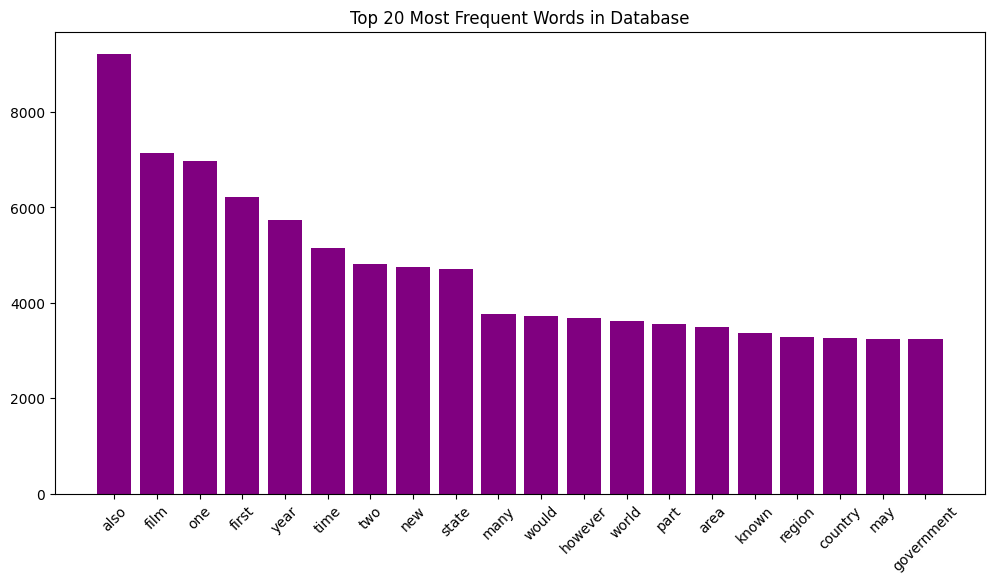

In [21]:
all_text = " ".join(df['wordnet_lemmatized'].dropna())
words = all_text.split()
word_freq = Counter(words)

top_words = word_freq.most_common(20)
print("Top 20 words:", top_words)

plt.figure(figsize=(12,6))
plt.bar(*zip(*top_words), color = 'purple')
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words in Database")
plt.show()


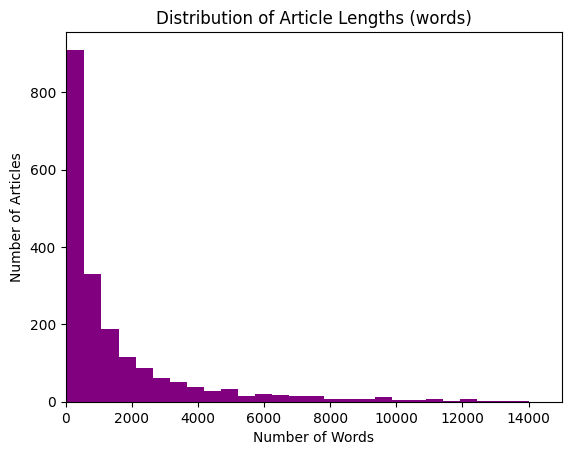

In [22]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

plt.figure()
plt.hist(df['word_count'], bins=50, color='purple')
plt.title("Distribution of Article Lengths (words)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Articles")
plt.xlim(0, 15000)
plt.show()


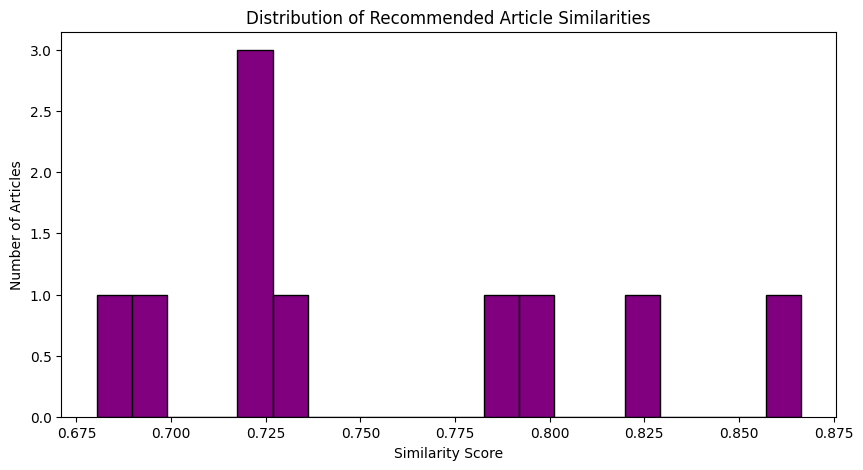

In [23]:
plt.figure(figsize=(10,5))
plt.hist(r['similarity'], bins=20, color='purple', edgecolor='black')
plt.title("Distribution of Recommended Article Similarities")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Articles")
plt.show()


In [24]:
def recommendation_word_contributions(user_df, recommended_df, top_n=5, top_words=10):
    user_texts = user_df['wordnet_lemmatized'].tolist()
    rec_texts = recommended_df['wordnet_lemmatized'].tolist()[:top_n]
    rec_urls = recommended_df['url'].tolist()[:top_n]

    vectorizer = TfidfVectorizer(max_features=10000)
    tfidf_matrix = vectorizer.fit_transform(user_texts + rec_texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    user_tfidf = tfidf_matrix[:len(user_texts)]
    rec_tfidf = tfidf_matrix[len(user_texts):]

    sim_matrix = cosine_similarity(rec_tfidf, user_tfidf)

    for i, url in enumerate(rec_urls):

        contribution_vector = rec_tfidf[i].multiply(user_tfidf[0])
        contribution_vector = np.array(contribution_vector.todense()).flatten()
        top_indices = contribution_vector.argsort()[::-1][:top_words]
        top_contrib_words = feature_names[top_indices]
        top_contrib_scores = contribution_vector[top_indices]

        plt.figure(figsize=(10, 4))
        plt.bar(top_contrib_words, top_contrib_scores, color='lightpink')
        plt.xticks(rotation=45)
        plt.ylabel("Weighted Contribution (TF-IDF product)")
        plt.title(f"Top {top_words} Words Driving Similarity for Article {i+1}")
        plt.show()

        plt.figure(figsize=(6, 3))
        plt.bar([f"Url {k+1}" for k in range(len(user_texts))], sim_matrix[i], color='purple')
        plt.ylim(0, 1)
        plt.ylabel("Cosine Similarity")
        plt.title(f"Similarity of Recommended Article {i+1} to User Articles")
        plt.show()


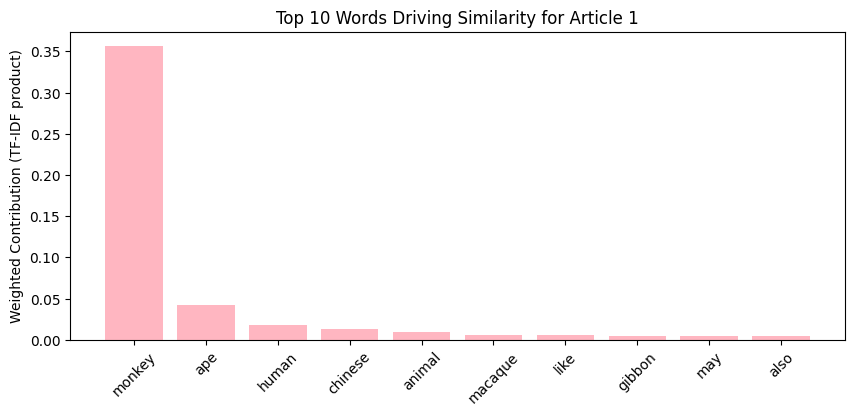

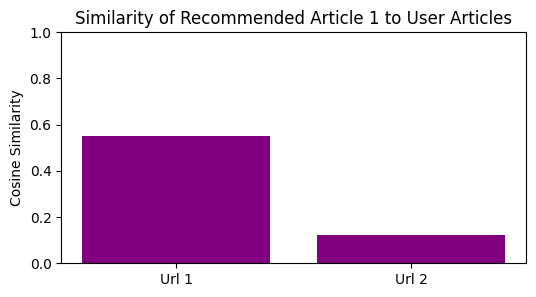

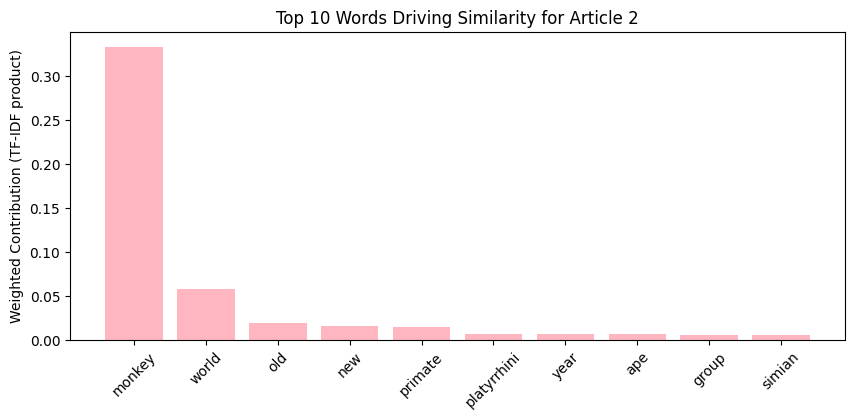

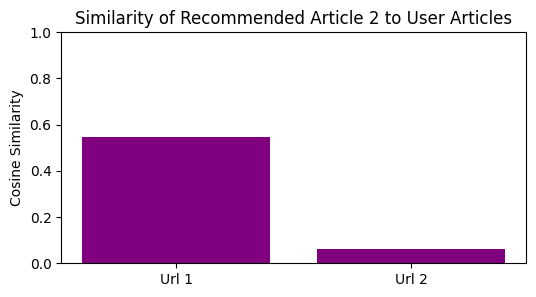

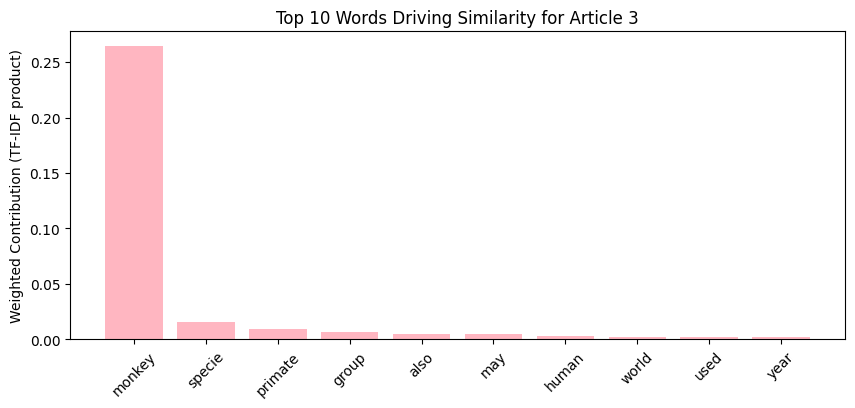

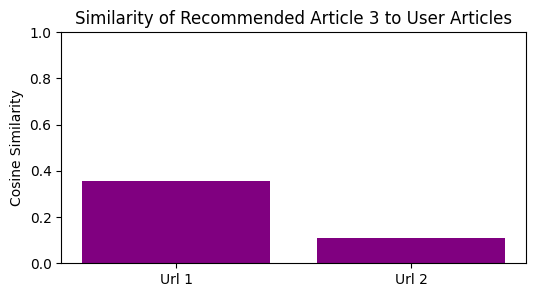

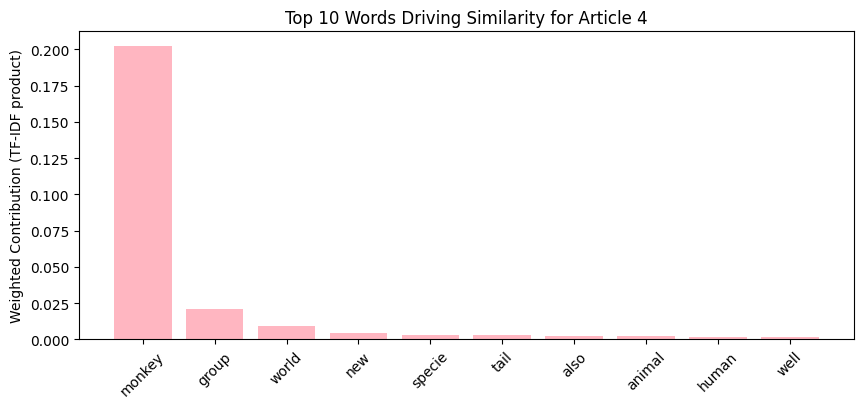

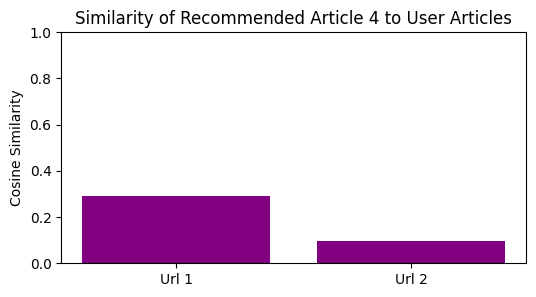

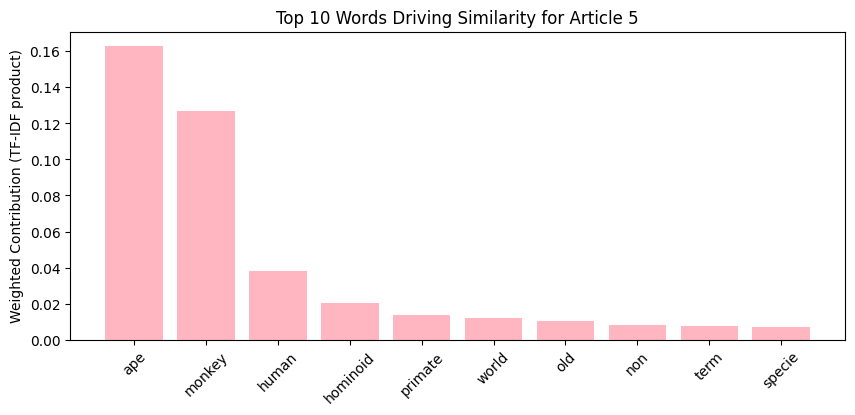

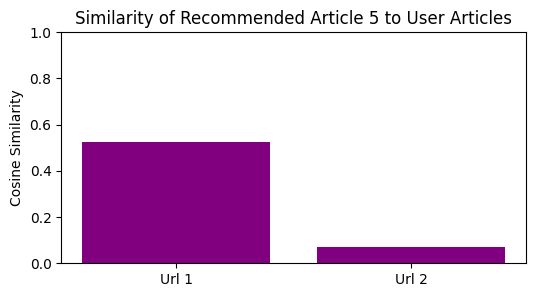

In [25]:
recommendation_word_contributions(user_df, r, top_n=5, top_words=10)


In [26]:
plot_df = pd.concat([user_df, r]).drop_duplicates(subset='url').reset_index(drop=True)

texts_to_plot = plot_df['text'].tolist()
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(texts_to_plot)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
plot_df['x'] = reduced[:, 0]
plot_df['y'] = reduced[:, 1]


In [27]:
plot_df['type'] = ['user'] * len(user_df) + ['recommended'] * (len(plot_df) - len(user_df))


In [28]:
fig = px.scatter(
    plot_df,
    x='x',
    y='y',
    color='type',
    color_discrete_map={'user': 'lightpink', 'recommended': 'purple'},
    text='title'
)

fig.update_traces(
    textposition='bottom center',
    marker=dict(size=12)
)

fig.update_layout(
    template='plotly',
    title="User Articles vs Top Recommended Articles"
)

fig.show()


/tmp/ipython-input-1196218349.py:22: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:purple'` for the same effect.




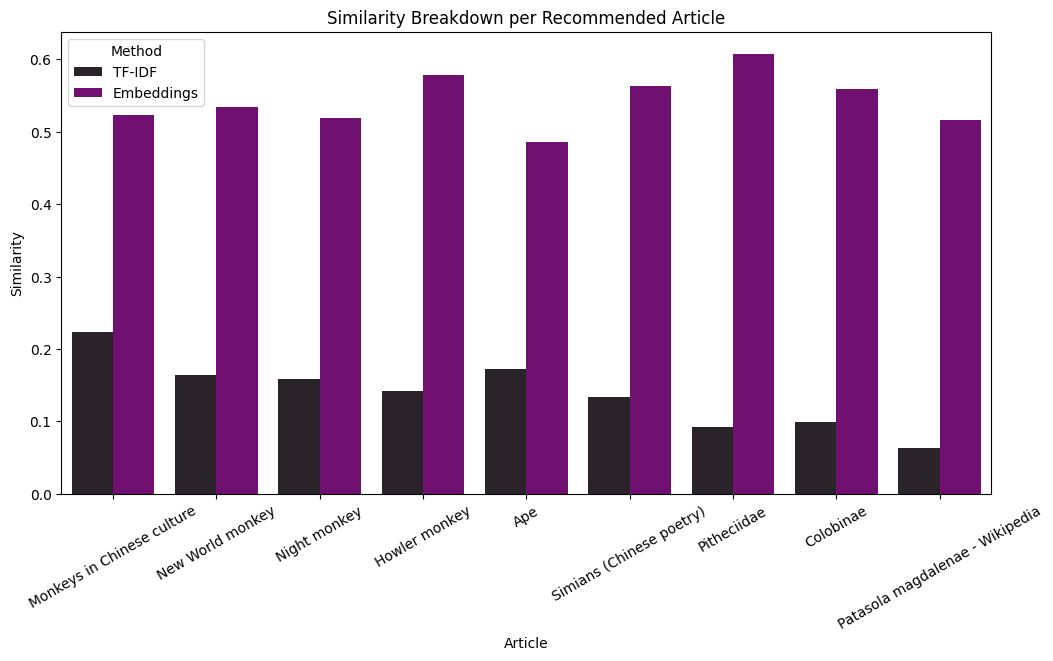

In [29]:
import seaborn as sns

def plot_recommendation_breakdown(user_texts, article_texts, top_articles):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sentence_transformers import SentenceTransformer
    import numpy as np

    # TF-IDF similarity
    tfidf_sim = compute_tfidf_similarity(" ".join(user_df['wordnet_lemmatized']), top_articles['wordnet_lemmatized'])
    # Embedding similarity
    embed_sim = compute_embedding_similarity(user_df['text'].tolist(), top_articles['text'].tolist())

    df_plot = pd.DataFrame({
        "Article": top_articles['title'].tolist(),
        "TF-IDF": tfidf_sim,
        "Embeddings": embed_sim
    })

    df_plot_melt = df_plot.melt(id_vars='Article', var_name='Method', value_name='Similarity')

    plt.figure(figsize=(12,6))
    sns.barplot(x='Article', y='Similarity', hue='Method', data=df_plot_melt, color = 'purple')
    plt.xticks(rotation=30)
    plt.title("Similarity Breakdown per Recommended Article")
    plt.show()

plot_recommendation_breakdown(user_df['text'], df['text'], r.head(10))
